In [34]:
import lzma
import pickle

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from neural_network import NeuralNetwork

In [35]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


# Load and preprocess your collected data


In [36]:
from statistics import mean

snapshots = []

for i in range(11):
    with lzma.open(f"../record_{i}.npz", "rb") as file:
        data = pickle.load(file)
        avg_speed = mean([d.car_speed for d in data])
        print(f"record_{i} average speed: {avg_speed}")
        # if avg_speed < 38:
        snapshots = snapshots + data

record_0 average speed: 37.4117920554004
record_1 average speed: 40.77769929909509
record_2 average speed: 41.30762935273441
record_3 average speed: 40.1125858757231
record_4 average speed: 38.769415028717205
record_5 average speed: 37.461681267389885
record_6 average speed: 40.32858584030815
record_7 average speed: 39.806681031603446
record_8 average speed: 41.6986648238131
record_9 average speed: 41.80501332617643
record_10 average speed: 39.59026164436772


In [37]:
X_scalar_list = [
    [s.car_speed, *s.raycast_distances]
    for s in snapshots
]
X_image_list = [s.image for s in snapshots]

# 2. Create the list of labels (y). The original list comprehension was a bit complex.
y_list = [s.current_controls for s in snapshots]

# 3. Convert all lists to NumPy arrays with a specific data type
features = np.array(X_scalar_list, dtype=np.float32)
labels = np.array(y_list, dtype=np.float32)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Define your neural network model


In [38]:
model = NeuralNetwork().to(device)
model

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
    (5): Sigmoid()
  )
)

# Set up training loop with loss function and optimizer

In [39]:
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=5e-4)

# Train the model and save checkpoints


In [40]:
from torch.utils.data import Dataset

class Data(Dataset):
    def __init__(self, X, y):
        self.features = torch.from_numpy(X.astype(np.float32))
        self.labels = torch.from_numpy(y.astype(np.float32))  # Changed from int32 to float32
        self.len = self.features.shape[0]
       
    def __getitem__(self, index):
        return self.features[index], self.labels[index]
   
    def __len__(self):
        return self.len

In [41]:
batch_size = 32

train_data = Data(X_train, y_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = Data(X_test, y_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

In [42]:
num_epochs = 100
loss_values = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for features, labels in train_dataloader:
        # zero the parameter gradients
        optimizer.zero_grad()
       
        # forward + backward + optimize
        pred = model(features)
        loss = criterion(pred, labels)
        total_loss += loss.item()
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_dataloader)}")

Epoch 1, Loss: 0.7289083699385325
Epoch 2, Loss: 0.5700789351354946
Epoch 3, Loss: 0.530784648476225
Epoch 4, Loss: 0.5032696010488452
Epoch 3, Loss: 0.530784648476225
Epoch 4, Loss: 0.5032696010488452
Epoch 5, Loss: 0.48632402988997375
Epoch 6, Loss: 0.4689473080815691
Epoch 5, Loss: 0.48632402988997375
Epoch 6, Loss: 0.4689473080815691
Epoch 7, Loss: 0.4564738029783422
Epoch 8, Loss: 0.44773793626915326
Epoch 7, Loss: 0.4564738029783422
Epoch 8, Loss: 0.44773793626915326
Epoch 9, Loss: 0.4373647683497631
Epoch 10, Loss: 0.433509473547791
Epoch 9, Loss: 0.4373647683497631
Epoch 10, Loss: 0.433509473547791
Epoch 11, Loss: 0.42515163033297565
Epoch 12, Loss: 0.41974147702708386
Epoch 11, Loss: 0.42515163033297565
Epoch 12, Loss: 0.41974147702708386
Epoch 13, Loss: 0.41589370144136023
Epoch 14, Loss: 0.4123011249484438
Epoch 15, Loss: 0.4081071023688172
Epoch 13, Loss: 0.41589370144136023
Epoch 14, Loss: 0.4123011249484438
Epoch 15, Loss: 0.4081071023688172
Epoch 16, Loss: 0.406030731219

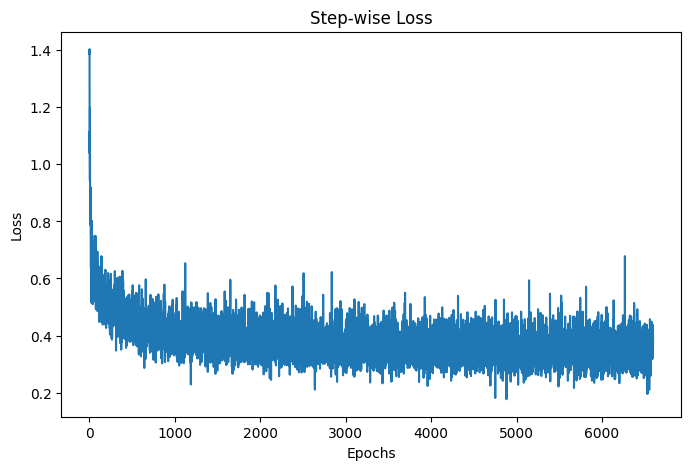

In [43]:
import matplotlib.pyplot as plt

step = range(len(loss_values))

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values))
plt.title("Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Evaluate performance on validation data


In [44]:
# Evaluate the model on test data
model.eval()
correct = 0
total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for features, labels in test_dataloader:
        outputs = model(features)  # Get model outputs (probabilities from sigmoid)
        
        # Convert probabilities to binary predictions (0 or 1)
        predicted = (outputs >= 0.6).float()
        
        # Calculate accuracy per element (since we have 4 outputs per sample)
        correct += (predicted == labels).sum().item()
        total += labels.numel()  # Total number of elements (batch_size * 4)
        
        # Store for later analysis if needed
        all_predictions.append(predicted.numpy())
        all_labels.append(labels.numpy())

# Calculate overall accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the network on the test set: {accuracy:.2f}%')
print(f'Total predictions: {total} (across {total//4} samples with 4 controls each)')

# Optionally, calculate per-control accuracy
all_predictions = np.vstack(all_predictions)
all_labels = np.vstack(all_labels)

print("\nPer-control accuracy:")
for i, control in enumerate(['Forward', 'Backward', 'Left', 'Right']):
    control_correct = (all_predictions[:, i] == all_labels[:, i]).sum()
    control_total = len(all_predictions)
    control_accuracy = 100 * control_correct / control_total
    print(f'  {control}: {control_accuracy:.2f}%')

Accuracy of the network on the test set: 85.76%
Total predictions: 2092 (across 523 samples with 4 controls each)

Per-control accuracy:
  Forward: 78.97%
  Backward: 95.03%
  Left: 86.04%
  Right: 82.98%


# Save the trained model

In [45]:
# Save the trained model
model_save_path = "trained_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# You can also save with additional info
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'final_loss': loss_values[-1] if loss_values else None,
    'accuracy': accuracy
}
torch.save(checkpoint, "trained_model_checkpoint.pth")
print("Checkpoint saved to trained_model_checkpoint.pth")

Model saved to trained_model.pth
Checkpoint saved to trained_model_checkpoint.pth
